In [18]:
%matplotlib inline
import cv2
from pylab import *

In [19]:
rcParams['figure.figsize'] = 15, 15

In [20]:
import torch
from torch import nn

In [21]:
from unet_models import unet11

In [22]:
from pathlib import Path

In [23]:
from torch.nn import functional as F

In [24]:
from torch.autograd import Variable

In [25]:
from torchvision.transforms import ToTensor, Normalize, Compose

In [26]:
def variable(x, volatile=False):
    if isinstance(x, (list, tuple)):
        return [variable(y, volatile=volatile) for y in x]
    return cuda(Variable(x, volatile=volatile))

In [ ]:
children

In [27]:
def get_model():
    model = unet11(pretrained='carvana')
    model.eval()
    return model.cuda()

In [28]:
def mask_overlay(image, mask, color=(0, 255, 0)):
    """
    Helper function to visualize mask on the top of the car
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]    
    return img

In [29]:
def cuda(x):
    return x.cuda(async=True) if torch.cuda.is_available() else x

In [30]:
def load_image(path, pad=True):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 32 (newtwork requirement)
    
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if not pad:
        return img
    
    height, width, _ = img.shape
    
    if height % 32 == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = 32 - height % 32
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad
        
    if width % 32 == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = 32 - width % 32
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad
    
    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)

    return img, (x_min_pad, y_min_pad, x_max_pad, y_max_pad)

In [31]:
img_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [32]:
def crop_image(img, pads):
    """
    img: numpy array of the shape (height, width)
    pads: (x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    
    @return padded image
    """
    (x_min_pad, y_min_pad, x_max_pad, y_max_pad) = pads
    height, width = img.shape[:2] 
    
    return img[y_min_pad:height - y_max_pad, x_min_pad:width - x_max_pad]
    

In [16]:
model = get_model()

# Example on Carvana dataset car

In [33]:
img, pads = load_image('lexus.jpg', pad=True)

In [37]:
img.shape

(1280, 1920, 3)

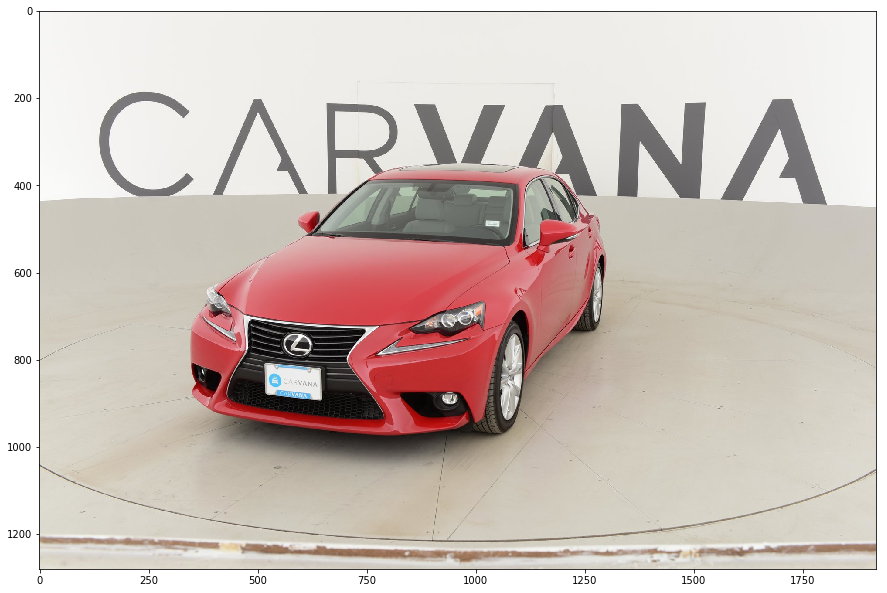

In [34]:
imshow(img)

In [62]:
input_img = torch.unsqueeze(variable(img_transform(img), volatile=True), dim=0)

In [63]:
input_img.shape

torch.Size([1, 3, 1280, 1920])

In [20]:
mask = F.sigmoid(model(input_img))

In [21]:
mask_array = mask.data[0].cpu().numpy()[0]

In [22]:
mask_array = crop_image(mask_array, pads)

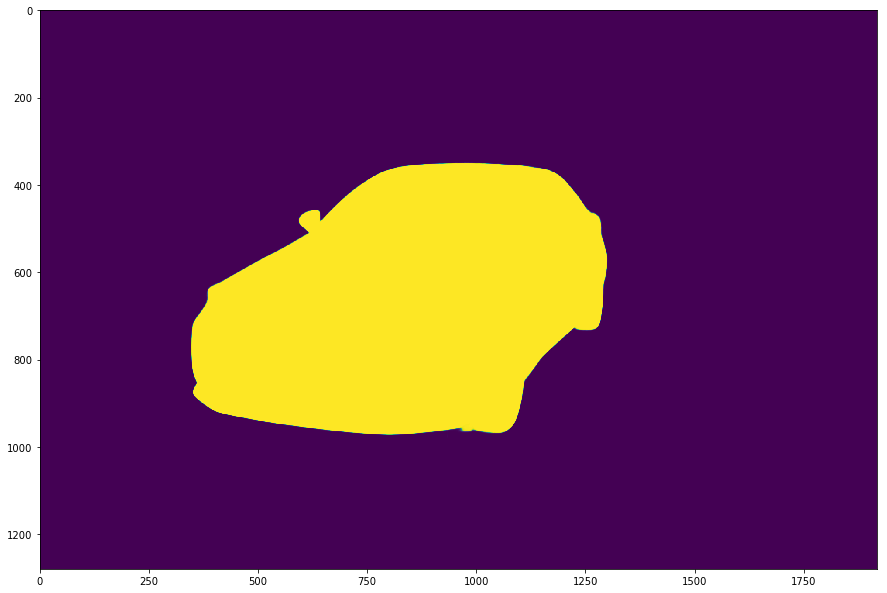

In [23]:
imshow(mask_array)

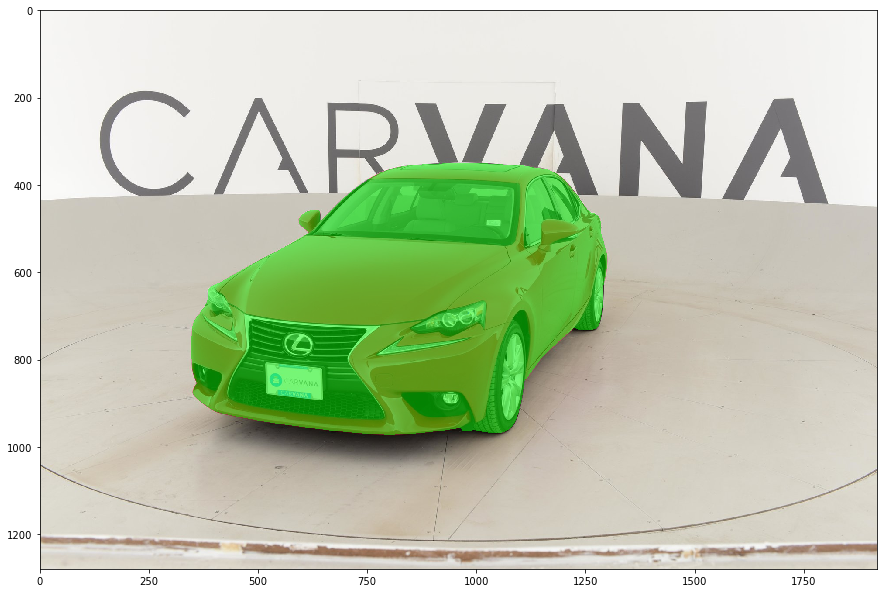

In [24]:
imshow(mask_overlay(crop_image(img, pads), (mask_array > 0.5).astype(np.uint8)))